Disclaimer: By any model I mean model that is in the Timm library

In [1]:
import numpy as np # linear algebra
import pandas as pd
import cv2
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader

timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"
import sys
sys.path.append(timm_path)
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
df  = pd.read_csv("../input/shopee-product-matching/train.csv")


In [3]:
import os
img_path = '../input/shopee-product-matching/train_images'
paths = [os.path.join(img_path,x) for x in df.image]
df['path'] = paths
df.head()

,posting_id,image,image_phash,title,label_group,path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...


In [4]:
n_labels = df.label_group.nunique()
n_labels

11014

In [5]:
n_hash = df.image_phash.nunique()
n_hash

28735

In [6]:
train_aug = A.Compose(
    [  

        A.Resize(224,224,p=1.0),
     A.Normalize(p=1.0),
        ToTensorV2(p=1.0)
    ]
)

In [7]:
class Shop(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_src = self.df.path.iloc[idx]
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        p_id =  self.df.posting_id.iloc[idx]
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        
        return image,p_id 

In [8]:
class emb_Model(nn.Module):
    def __init__(self,op_size= 42,f_size=64):
        super().__init__()
        self.f = f_size
        self.op = 42
        
        self.m = timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
        num_features = self.m.classifier.in_features
        self.m.classifier = nn.Linear(num_features,self.f)
        self.fc = nn.Linear(self.f,self.op)
        
    def forward(self,x):
        feat = self.m(x)
        y = F.relu(feat)
        y = self.fc(y)
        
        return feat,y

In [9]:
dx =df.copy()
dx.set_index('posting_id', inplace=True)

In [10]:
embs =[ii for ii in range(64)] ##equal to the output size of the neural net
dx[embs] = 0
dx.head()

,image,image_phash,title,label_group,path,0,1,2,3,4,...,54,55,56,57,58,59,60,61,62,63
posting_id,,,,,,,,,,,,,,,,,,,,,
train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
da = Shop(df,augs=train_aug)

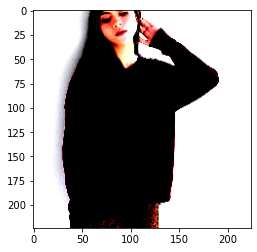

In [12]:
plt.imshow(da[10][0].permute(1,2,0))

In [13]:
loader =  DataLoader(da,shuffle=False,
                        num_workers=4,
                        batch_size=1)


In [14]:
modelx =  emb_Model()
#WEIGHTS_FILE = '../input/classification-pipeline-on-previous-shoplee-data/model with val_acc 0.5636920011386279.pth'
WEIGHTS_FILE = '../input/classification-pipeline-on-previous-shoplee-data/model with val_acc 0.771420438371762.pth'
modelx.load_state_dict(torch.load(WEIGHTS_FILE))
modelx.to(device)
modelx.eval()
for img,indx in loader:
    img = img.to(device)
    with torch.no_grad():
        op,_ = modelx(img)
    op = op.squeeze(0)
    dx.loc[indx,embs] = op.detach().cpu().numpy()
    
    

In [15]:
dx.to_csv('embeddings.csv')
dx.head()

,image,image_phash,title,label_group,path,0,1,2,3,4,...,54,55,56,57,58,59,60,61,62,63
posting_id,,,,,,,,,,,,,,,,,,,,,
train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,-1.976923,-0.394076,-1.116356,1.390578,5.570573,...,1.148851,-0.666444,-1.355045,0.869244,1.331210,2.937347,0.199661,5.449000,2.549921,1.856575
train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,1.902338,3.962437,-0.073144,-0.949685,0.374160,...,-1.721954,0.047379,-0.043569,-2.155312,3.219642,5.861103,-1.557483,1.170609,0.256603,1.538829
train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,9.989271,1.747680,1.404027,9.970988,2.491323,...,-2.122145,-2.275242,-3.242596,2.032735,7.445390,3.882680,-1.477237,-3.395977,0.612772,6.033319
train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...,-1.703672,-8.496656,-0.708127,-1.441379,-8.838904,...,4.808806,1.891527,10.753779,2.330132,-10.164821,-2.032707,-4.423727,-5.751026,-2.981659,13.960304
train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...,-2.291808,-1.650976,-0.249996,-3.702528,0.345318,...,2.482360,0.198236,-2.219872,4.260627,-3.412425,-1.768922,-0.237294,6.575355,1.896471,1.626202
